Name: Aditya Gujar<br>
Reg no: 2448505<br>
Lab-4

## Imports and Audio Loading

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal

file_path = 'audio_files/alien-talking.mp3'  
y, sr = librosa.load(file_path, sr=16000)
print(f"Loaded audio: {y.shape}, sample rate: {sr}")


Loaded audio: (129568,), sample rate: 16000


## Plot Original Speech Signal

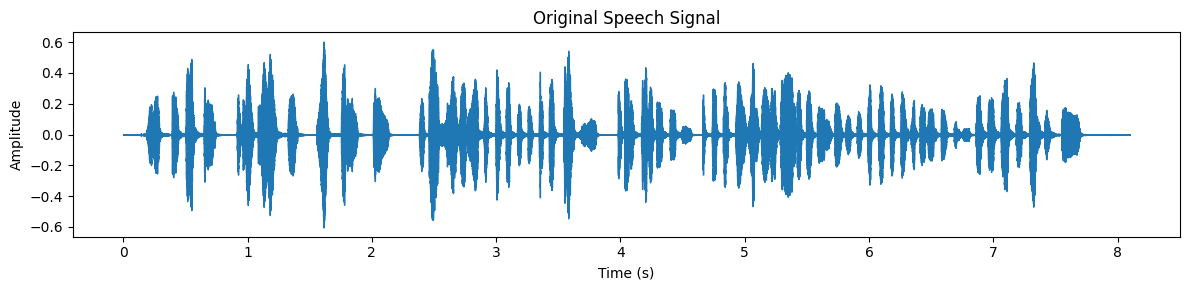

In [4]:
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Original Speech Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


## LPC Analysis (LPC Coefficients Extraction)

In [5]:
# Use a typical LPC order for speech (usually 12–16)
lpc_order = 16

# Frame selection for analysis (single voiced region e.g. from 1s to 1.02s)
start_sample = int(1.0 * sr)
end_sample = int(1.02 * sr)
frame = y[start_sample:end_sample]

# LPC analysis using librosa
lpc_coeffs = librosa.lpc(frame, order=lpc_order)
print("LPC Coefficients:", lpc_coeffs)


LPC Coefficients: [1.         0.14710401 1.0190303  0.430265   1.4328935  0.3528126
 1.014093   0.7774962  0.9352615  0.7568896  0.88262904 0.95082164
 0.7879513  0.44655657 0.37005162 0.25242114 0.17946188]


## Signal Reconstruction from LPC Coefficients

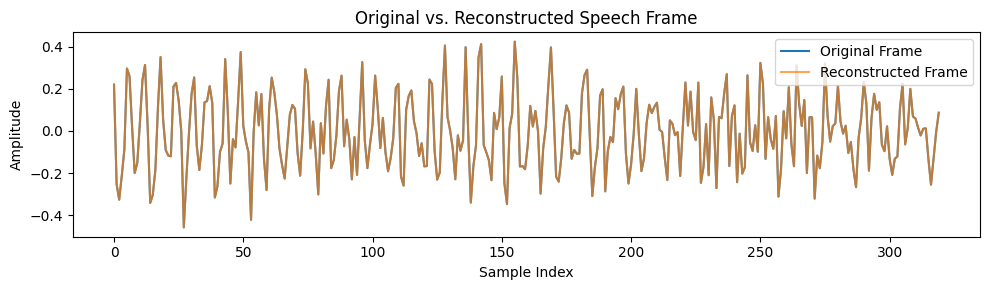

In [6]:
# Filter the excitation (residual) to reconstruct the speech frame
excitation = scipy.signal.lfilter(lpc_coeffs, 1, frame)

# Reconstruct signal (inverse filter)
reconstructed = scipy.signal.lfilter([1], lpc_coeffs, excitation)

plt.figure(figsize=(10, 3))
plt.plot(frame, label='Original Frame')
plt.plot(reconstructed, label='Reconstructed Frame', alpha=0.7)
plt.title('Original vs. Reconstructed Speech Frame')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


## Formant Estimation from LPC Coefficients

In [7]:
# Calculate the roots of the LPC polynomial
rts = np.roots(lpc_coeffs)
rts = [r for r in rts if np.imag(r) >= 0]
angz = np.arctan2(np.imag(rts), np.real(rts))

# Convert to Hz
formant_freqs = sorted(angz * (sr / (2 * np.pi)))
# Only keep those in expected speech frequency range (e.g., >90 Hz and <4000 Hz)
formant_freqs = [f for f in formant_freqs if 90 < f < 4000]
print("Estimated Formant Frequencies (Hz):", formant_freqs[:3])


Estimated Formant Frequencies (Hz): [np.float32(1150.5118), np.float32(2381.0212), np.float32(2446.6248)]


## Frequency Response and Formant Visualization

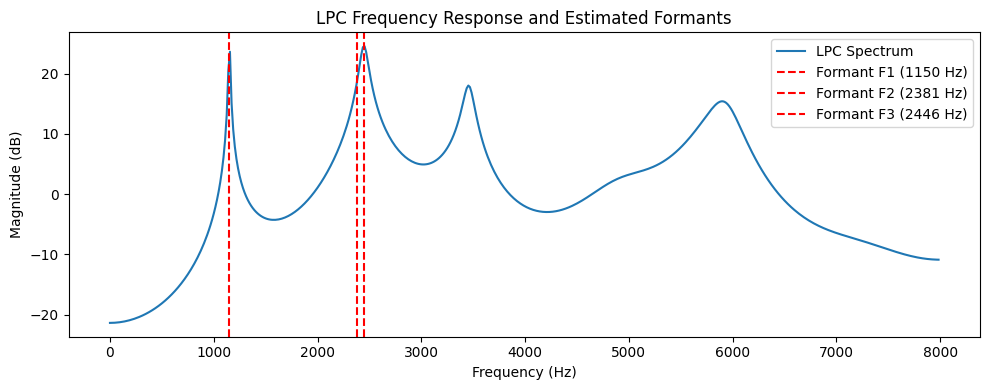

In [8]:
# Get frequency response of the LPC model
w, h = scipy.signal.freqz([1], lpc_coeffs, worN=512, fs=sr)
plt.figure(figsize=(10, 4))
plt.plot(w, 20 * np.log10(np.abs(h)), label='LPC Spectrum')
for i, f in enumerate(formant_freqs[:3]):
    plt.axvline(f, color='r', linestyle='--', label=f'Formant F{i+1} ({int(f)} Hz)')
plt.title("LPC Frequency Response and Estimated Formants")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.tight_layout()
plt.show()


## Standard Vowel Formant Comparison (Table)

In [10]:
import pandas as pd

# Reference formant values for comparison (male averages)
vowels = ['i', 'e', 'a', 'u', 'o']
f1_std = [240, 390, 850, 250, 360]
f2_std = [2400, 2300, 1610, 595, 640]

# Estimated from above (example, replace as needed)
f1_est = [int(formant_freqs[0]) if len(formant_freqs) > 0 else np.nan] * 5
f2_est = [int(formant_freqs[1]) if len(formant_freqs) > 1 else np.nan] * 5

df = pd.DataFrame({
    'Vowel': vowels,
    'F1 Standard (Hz)': f1_std,
    'F2 Standard (Hz)': f2_std,
    'Estimated F1 (Hz)': f1_est,
    'Estimated F2 (Hz)': f2_est,
})
df


,Vowel,F1 Standard (Hz),F2 Standard (Hz),Estimated F1 (Hz),Estimated F2 (Hz)
0,i,240,2400,1150,2381
1,e,390,2300,1150,2381
2,a,850,1610,1150,2381
3,u,250,595,1150,2381
4,o,360,640,1150,2381
